# I. Import Libraries

In [1]:
import time
import joblib
import os
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    brier_score_loss, classification_report, confusion_matrix, precision_recall_curve)
from sklearn.calibration import (calibration_curve, CalibratedClassifierCV)
from sklearn.model_selection import (train_test_split, RandomizedSearchCV, StratifiedKFold)
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# II. Load Data

In [2]:
data = pd.read_csv("diabetes_dataset.csv")

# III. Split Data (80/20)

In [3]:
# แยก Features (x) และ Target (y)
x = pd.get_dummies(data.drop("diabetes", axis=1), drop_first=True)
y = data["diabetes"]

In [4]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

print("Dataset 100% :", data.shape)
print("x train Set 80% :", x_train.shape)
print("x test Set 20% :", x_test.shape)
print("y train Set 80% :", y_train.shape)
print("y Test Set 20% :", y_test.shape)

Dataset 100% : (100000, 9)
x train Set 80% : (80000, 13)
x test Set 20% : (20000, 13)
y train Set 80% : (80000,)
y Test Set 20% : (20000,)


# IV. Training Model

In [5]:
param_dist = {
 'n_estimators': [50,100,200,400],
 'learning_rate': [0.01,0.03,0.05,0.1,0.2],
 'max_depth': [3,4,5,6,8],
 'min_child_weight': [1,3,5,7],
 'gamma': [0,0.1,0.3,0.5],
 'subsample': [0.6,0.7,0.8,0.9,1.0],
 'colsample_bytree': [0.6,0.7,0.8,0.9,1.0],
 'reg_alpha': [0,0.01,0.1,1],
 'reg_lambda': [0.5,1,2,5]}
cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
rs = RandomizedSearchCV(xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
                       param_distributions=param_dist, n_iter=50, scoring='roc_auc', cv=cv, n_jobs=-1, random_state=42)
rs.fit(x_train, y_train)
print(rs.best_params_)

c:\Users\Tutu\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:51:41] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


{'subsample': 1.0, 'reg_lambda': 2, 'reg_alpha': 0, 'n_estimators': 200, 'min_child_weight': 1, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0.3, 'colsample_bytree': 0.6}


In [6]:
neg = (y_train==0).sum()
pos = (y_train==1).sum()
scale_pos_weight = neg/pos
model = xgb.XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    n_estimators=200,
    min_child_weight=1,
    gamma=0.3,
    learning_rate=0.1,
    max_depth=4,
    subsample=1,
    reg_alpha=0,
    reg_lambda=2,
    colsample_bytree=0.6,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss')
calibrated = CalibratedClassifierCV(model, method='sigmoid', cv=5)

calibrated.fit(x_train, y_train)
y_prob = calibrated.predict_proba(x_test)[:, 1]
prec, rec, thr = precision_recall_curve(y_test, y_prob)

f1s = 2 * (prec * rec) / (prec + rec + 1e-9)
best_idx = None
for i, (p, r) in enumerate(zip(prec, rec)):
    if r >= 0.8 and p >= 0.9:
        best_idx = i
        break

if best_idx:
    best_threshold = thr[best_idx]
else:
    best_threshold = 0.5  # fallback

print("Best threshold (Recall>=0.8, Precision>=0.9):", best_threshold)
y_pred = (y_prob >= best_threshold).astype(int)


c:\Users\Tutu\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:51:42] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Tutu\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:51:43] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Tutu\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:51:44] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Tutu\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:51:44] WARNING: C:\actions-r

Best threshold (Recall>=0.8, Precision>=0.9): 0.5


# V. Model Result

## A) ROC-AUC Score, Accuracy, Precision, Recall, F1-score, Brier Score

In [7]:
roc_auc = roc_auc_score(y_test, y_prob)
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
brier = brier_score_loss(y_test, y_prob)

print(f"ROC-AUC Score: {roc_auc:.4f}")
print(f"Accuracy     : {acc:.4f}")
print(f"Precision    : {prec:.4f}")
print(f"Recall       : {rec:.4f}")
print(f"F1-score     : {f1:.4f}")
print(f"Brier Score  : {brier:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

ROC-AUC Score: 0.9800
Accuracy     : 0.9665
Precision    : 0.8284
Recall       : 0.7641
F1-score     : 0.7950
Brier Score  : 0.0257

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.98     18300
           1       0.83      0.76      0.79      1700

    accuracy                           0.97     20000
   macro avg       0.90      0.87      0.89     20000
weighted avg       0.97      0.97      0.97     20000


Confusion Matrix:
 [[18031   269]
 [  401  1299]]


## B.) Calibration Curve

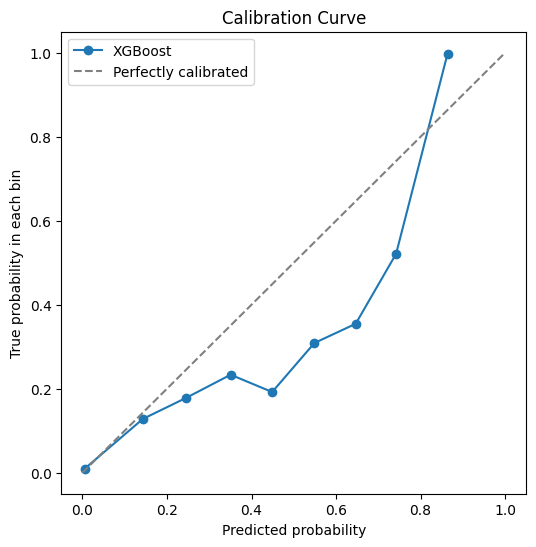

In [8]:
prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10)

plt.figure(figsize=(6, 6))
plt.plot(prob_pred, prob_true, marker="o", label="XGBoost")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Perfectly calibrated")
plt.xlabel("Predicted probability")
plt.ylabel("True probability in each bin")
plt.title("Calibration Curve")
plt.legend()
plt.show()

## C.) Inference Latency

In [9]:
start_time = time.time()
_ = calibrated.predict(x_test)
latency = (time.time() - start_time) / len(x_test)  # Average Time 1 instance
print(f"Inference Latency: {latency*1000:.4f} ms per sample")

Inference Latency: 0.0145 ms per sample


## D.) Model Size

In [10]:
joblib.dump(model, "logreg_model.pkl")
model_size = os.path.getsize("logreg_model.pkl") / 1024  # KB
print(f"Model Size: {model_size:.2f} KB")

Model Size: 0.91 KB
